lab9: Quantum Kernel SVM  (Fidelity 기반)
  feature: ['petal length (cm)', 'petal width (cm)']
  N_QUBITS=2  |  N_REPEATS=1

  train: 105개, test: 45개
  클래스: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

  [Fidelity 커널 원리]
  IQP(x1) * adjoint(IQP(x2)) -> probs[0] = |<x1|x2>|^2
  x1 = x2 이면 fidelity = 1.0  (완전히 같은 상태)
  x1 != x2 이면 fidelity < 1.0 (다른 상태)

  커널 행렬 계산 중...
  K_train 형상: (105, 105)
  K_train 범위: 0.0024 ~ 1.0000
  대각선(자기 유사도) 평균: 1.0000  (이론: 1.0)


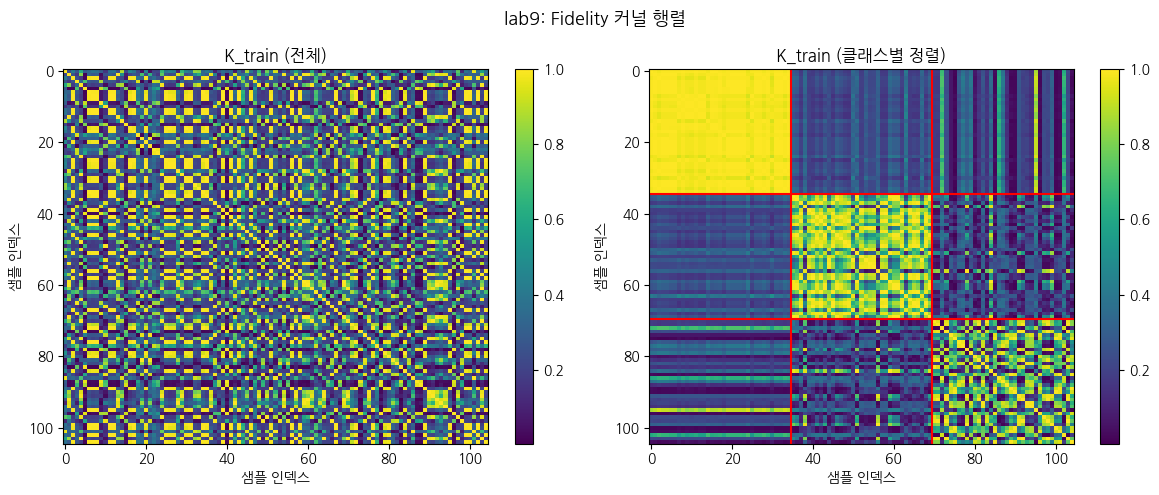

In [1]:
# !pip install pennylane koreanize_matplotlib scikit-learn -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
FEAT_IDX  = [2, 3]   # 사용할 feature: [0,1] / [2,3] / [0,1,2,3]
N_REPEATS = 1        # IQP 반복 횟수: 1 / 2
# ===== 수정 끝 =====
# ============================================================

N_QUBITS   = len(FEAT_IDX)
feat_names = [load_iris().feature_names[i] for i in FEAT_IDX]

print("=" * 60)
print("lab9: Quantum Kernel SVM  (Fidelity 기반)")
print("=" * 60)
print(f"  feature: {feat_names}")
print(f"  N_QUBITS={N_QUBITS}  |  N_REPEATS={N_REPEATS}")

# ===========================================================
#  1. 데이터 준비
# ===========================================================
iris     = load_iris()
X_raw    = iris.data[:, FEAT_IDX]
y        = iris.target

X = MinMaxScaler((0, std_np.pi)).fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_train = np.array(X_train)
X_test  = np.array(X_test)

print(f"\n  train: {len(X_train)}개, test: {len(X_test)}개")
print(f"  클래스: {list(iris.target_names)}")

# ===========================================================
#  2. Fidelity 양자 커널
# ===========================================================
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    qml.IQPEmbedding(x1, wires=range(N_QUBITS), n_repeats=N_REPEATS)
    qml.adjoint(qml.IQPEmbedding)(x2, wires=range(N_QUBITS),
                                   n_repeats=N_REPEATS)
    return qml.probs(wires=range(N_QUBITS))

def kernel(x1, x2):
    return float(kernel_circuit(x1, x2)[0])   # |<x1|x2>|² = fidelity

print("\n  [Fidelity 커널 원리]")
print("  IQP(x1) * adjoint(IQP(x2)) -> probs[0] = |<x1|x2>|^2")
print("  x1 = x2 이면 fidelity = 1.0  (완전히 같은 상태)")
print("  x1 != x2 이면 fidelity < 1.0 (다른 상태)")

# 커널 행렬 계산
print("\n  커널 행렬 계산 중...")
K_train = qml.kernels.kernel_matrix(X_train, X_train, kernel)
K_test  = qml.kernels.kernel_matrix(X_test,  X_train, kernel)

print(f"  K_train 형상: {K_train.shape}")
print(f"  K_train 범위: {K_train.min():.4f} ~ {K_train.max():.4f}")
print(f"  대각선(자기 유사도) 평균: {std_np.diag(K_train).mean():.4f}  (이론: 1.0)")

# 커널 행렬 heatmap
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("lab9: Fidelity 커널 행렬", fontsize=13)

im = axes[0].imshow(K_train, cmap='viridis', aspect='auto')
plt.colorbar(im, ax=axes[0])
axes[0].set_title("K_train (전체)")
axes[0].set_xlabel("샘플 인덱스"); axes[0].set_ylabel("샘플 인덱스")

# 클래스별 정렬된 heatmap
sort_idx  = std_np.argsort(y_train)
K_sorted  = K_train[std_np.ix_(sort_idx, sort_idx)]
im2 = axes[1].imshow(K_sorted, cmap='viridis', aspect='auto')
plt.colorbar(im2, ax=axes[1])
axes[1].set_title("K_train (클래스별 정렬)")
axes[1].set_xlabel("샘플 인덱스"); axes[1].set_ylabel("샘플 인덱스")

# 클래스 경계선
boundaries = [std_np.sum(y_train[sort_idx] == c) for c in range(3)]
pos = 0
for b in boundaries[:-1]:
    pos += b
    axes[1].axhline(pos - 0.5, color='red', lw=1.5)
    axes[1].axvline(pos - 0.5, color='red', lw=1.5)

plt.tight_layout(); plt.show()

In [2]:
# ===========================================================
#  3. QSVC vs RBF SVC 학습
# ===========================================================
print("\n" + "=" * 60)
print("lab9: QSVC vs RBF SVC 학습")
print("=" * 60)

# QSVC
qsvc = SVC(kernel="precomputed", decision_function_shape="ovr")
qsvc.fit(K_train, y_train)
qsvc_tr = round(qsvc.score(K_train, y_train), 4)
qsvc_te = round(qsvc.score(K_test,  y_test),  4)

# RBF SVC
rbf = SVC(kernel="rbf", gamma="scale", decision_function_shape="ovr")
rbf.fit(X_train, y_train)
rbf_tr = round(rbf.score(X_train, y_train), 4)
rbf_te = round(rbf.score(X_test,  y_test),  4)

print(f"\n  {'':>10s}  {'train Acc':>10s}  {'test Acc':>10s}")
print("  " + "-" * 35)
print(f"  {'QSVC':>10s}  {qsvc_tr:>10.4f}  {qsvc_te:>10.4f}")
print(f"  {'RBF SVC':>10s}  {rbf_tr:>10.4f}  {rbf_te:>10.4f}")


lab9: QSVC vs RBF SVC 학습

               train Acc    test Acc
  -----------------------------------
        QSVC      0.9619      0.9111
     RBF SVC      0.9810      0.9111


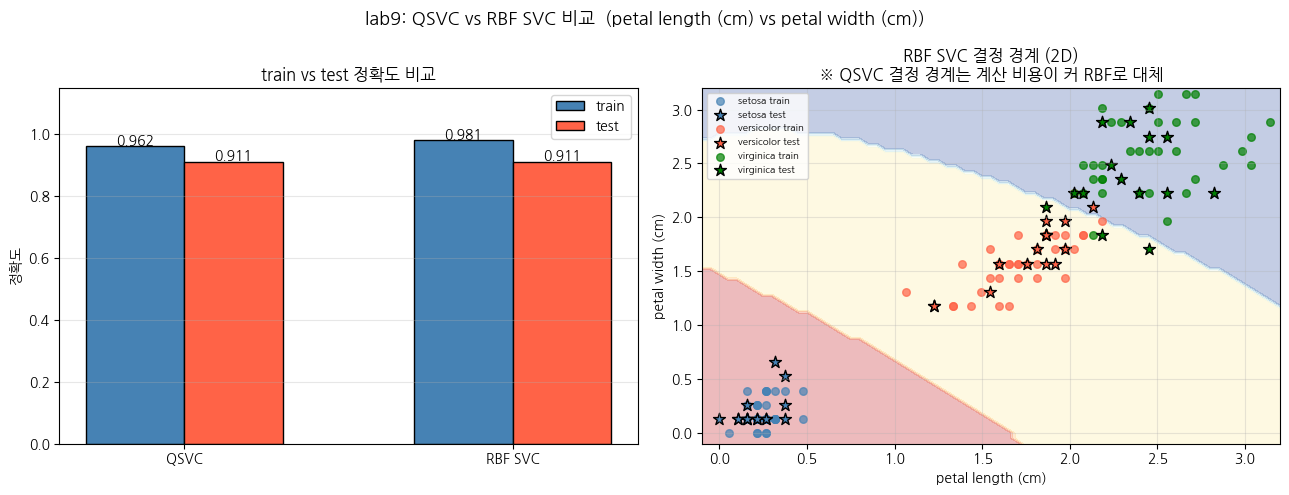


lab9 완료!


In [3]:

# ===========================================================
#  4. 시각화 -- 정확도 비교 + 결정 경계
# ===========================================================
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle(f"lab9: QSVC vs RBF SVC 비교  ({feat_names[0]} vs {feat_names[1]})",
             fontsize=13)

# 정확도 막대 비교
labels   = ['QSVC', 'RBF SVC']
tr_accs  = [qsvc_tr, rbf_tr]
te_accs  = [qsvc_te, rbf_te]
x_pos    = std_np.arange(2)
width    = 0.3

axes[0].bar(x_pos - width/2, tr_accs, width,
            color='steelblue', edgecolor='black', label='train')
axes[0].bar(x_pos + width/2, te_accs, width,
            color='tomato',    edgecolor='black', label='test')
for i, (tr, te) in enumerate(zip(tr_accs, te_accs)):
    axes[0].text(i - width/2, tr + 0.005, f'{tr:.3f}', ha='center', fontsize=10)
    axes[0].text(i + width/2, te + 0.005, f'{te:.3f}', ha='center', fontsize=10)
axes[0].set_xticks(x_pos); axes[0].set_xticklabels(labels)
axes[0].set_ylim(0, 1.15); axes[0].set_ylabel("정확도")
axes[0].set_title("train vs test 정확도 비교")
axes[0].legend(); axes[0].grid(axis='y', alpha=0.3)

# 결정 경계 (RBF SVC -- 빠른 계산)
h       = 0.05
x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy  = std_np.meshgrid(std_np.arange(x0_min, x0_max, h),
                           std_np.arange(x1_min, x1_max, h))
Z       = rbf.predict(std_np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

colors  = ['steelblue', 'tomato', 'green']
axes[1].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
for c, (name, color) in enumerate(zip(iris.target_names, colors)):
    mask_tr = y_train == c
    mask_te = y_test  == c
    axes[1].scatter(X_train[mask_tr, 0], X_train[mask_tr, 1],
                    c=color, s=30, alpha=0.7, label=f'{name} train')
    axes[1].scatter(X_test[mask_te, 0],  X_test[mask_te, 1],
                    c=color, s=80, marker='*', edgecolors='black',
                    label=f'{name} test')
axes[1].set_xlabel(feat_names[0]); axes[1].set_ylabel(feat_names[1])
axes[1].set_title("RBF SVC 결정 경계 (2D)\n※ QSVC 결정 경계는 계산 비용이 커 RBF로 대체")
axes[1].legend(fontsize=7); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

print("\nlab9 완료!")